# **<u>Computer Vision - Assignment 1: Dataset Preprocessing</u>**

Submitters' Details:
- Shy Ohev Zion - 318783479
- Aviad Hedvat - 207115205

---

### Goals
1. The original MNIST dataset includes images of single digits, in ten classes.<br>
   Our goal is to create a new three-digit image dataset, with 101 classes, based on the original MNIST dataset.

1. Create a dataset of shape images with three classes: (Triangle, Rectangle and Ellipse)

---

### General Summary of the Work
0. Work Setup
    - Import all necessary packages
    - Define general purpose configurations and functions 
    - Define 15 different augmentations (5 of which were defined as part of Lab 3), to be used for both parts of the task
    - Define random-augmentation-application methods
<br><br>
0.  Extending the MNIST Dataset
    - Import the MNIST dataset
    - Display a sample of each class of the dataset
    - Use the dataset to create an extension of it
    - Display sampled results with and without the augmentations randomly applied using the methods mentioned above 
<br><br>
0. Generating a shapes dataset
    - Define 'constants' to be used
    - Define parameter-generation methods for each class of shapes
    - Use the parameters to create a dataset of randomly generated shapes
    - Define a function that split the dataset to train and test datasets
    
---

## Imports, Configurations and General Functions Definitions

In [1]:
import cv2 as cv
import torchvision
import numpy as np
from typing import Tuple, Dict
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
import matplotlib.colors as mcolors
from PIL import Image, ImageFilter, ImageColor

In [2]:
grayscale_options = {"cmap": "gray", "vmin": 0, "vmax": 255}


def generate_seed(rng: np.random.Generator, limit: int = None):
    if limit is None:
        return None
    limit = [None] + list(range(limit))
    return rng.choice(limit)


def to_uint8(img: np.ndarray) -> np.ndarray:
    norm = np.uint32(img)
    return np.uint8(norm % 256)

## Augmentations:
below are 15 augmentations, categorized by "meaning" - geometric (affine) transformations, filters, and numeric manipulations and noise

### (GEOM)etric (affine) Transformations
- (F)lip
- (R)otate
- (T)ranslate
- (Z)oom
- (S)hear 

In [3]:
def flip(img: np.ndarray, seed: int = None) -> np.ndarray:
    rng = np.random.default_rng(seed)

    return np.flip(img, rng.integers(2))


def rotate(img: np.ndarray, theta: float) -> np.ndarray:

    rows, cols = img.shape[:2]
    center = np.array([rows, cols]) / 2.0

    x = np.arange(rows) - center[0]
    y = np.arange(cols) - center[1]

    xx, yy = np.meshgrid(x, y)

    cos, sin = np.cos(-theta), np.sin(-theta)

    xx_transformed = cos * xx - sin * yy + center[0]
    xx_transformed = xx_transformed.astype(int)

    yy_transformed = sin * xx + cos * yy + center[1]
    yy_transformed = yy_transformed.astype(int)

    rotated = np.zeros(img.shape, dtype=np.uint8)

    for index, _ in np.ndenumerate(rotated):
        row, col = index[:2]
        prev_row = xx_transformed[col, row]
        prev_col = yy_transformed[col, row]
        if 0 <= prev_row < rows and 0 <= prev_col < cols:
            rotated[row, col] = img[prev_row, prev_col]

    return rotated


def translate(img: np.ndarray, tx: int, ty: int) -> np.ndarray:
    M = np.float32([[1, 0, int(tx)], [0, 1, int(ty)]])
    return cv.warpAffine(img, M, (img.shape[1], img.shape[0])).astype(img.dtype)


def zoom(img: np.ndarray, ratio: float) -> np.ndarray:
    if not 0 < ratio:
        raise ValueError("zoom ratio must be positive")

    h, w = np.float32(img.shape[:2])
    _h, _w = h / 2, w / 2
    M = cv.getAffineTransform(
        src=np.float32([[0, _h], [_w, 0], [_w, _h]]),
        dst=np.float32([[_w * (1 - ratio), _h], [_w, _h * (1 - ratio)], [_w, _h]]),
    )
    return cv.warpAffine(img, M, (img.shape[1], img.shape[0])).astype(img.dtype)


def shear(img: np.ndarray, horizontal: bool = True, slope: float = 0) -> np.ndarray:
    M = np.float32([[1, 0, 0], [0, 1, 0]])
    if horizontal:
        M[0, 1] = slope
    else:
        M[1, 0] = slope

    M[0, 2] = -M[0, 1] * img.shape[0] / 2
    M[1, 2] = -M[1, 0] * img.shape[1] / 2

    return cv.warpAffine(img, M, (img.shape[1], img.shape[0])).astype(img.dtype)

### (FILT)ers:
- (SH)arpen
- (MEAN) filter
- (MED)ian filter
- (MODE) filter
- (GAUS)sian blur

In [4]:
def sharpen(img: np.ndarray) -> np.ndarray:
    sharpening_matrix = (1 / 9) * np.array([[-1, -1, -1], [-1, 17, -1], [-1, -1, -1]])
    if img.ndim == 2:
        sharpened = convolve2d(img, sharpening_matrix, mode="same")
        sharpened = to_uint8(sharpened)
    elif img.ndim == 3:
        sharpened = np.empty(img.shape)
        for i in range(img.shape[2]):
            sharpened_layer = convolve2d(img[:, :, i], sharpening_matrix, mode="same")
            sharpened[:, :, i] = to_uint8(sharpened_layer)

    else:
        raise NotImplementedError()

    return sharpened


def mean_filter(img: np.ndarray, kernel_size: int = 3) -> np.ndarray:
    kernel = np.ones((kernel_size, kernel_size)) / (kernel_size ** 2)
    filtered = convolve2d(img, kernel, mode="same", boundary="symm")
    return to_uint8(filtered)


def median_filter(img: np.ndarray, kernel_size: int = 3) -> np.ndarray:
    temp = np.pad(img, kernel_size // 2)
    filtered = np.zeros(img.shape, dtype=np.uint8)

    for (row, col), _ in np.ndenumerate(img):
        filtered[row, col] = np.median(
            temp[row : (row + kernel_size), col : (col + kernel_size)]
        )

    return filtered


def mode_filter(img: np.ndarray, kernel_size: int = 3) -> np.ndarray:
    img = cv.normalize(img, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)
    pil_img = Image.fromarray(img)
    res = pil_img.filter(ImageFilter.ModeFilter(kernel_size))
    return np.asarray(res).astype(np.uint8)


def gaussian_blurr(
    img: np.ndarray, kernel_size: int, sigma: float, val_range: float = 1
) -> np.ndarray:
    vals = np.linspace(-val_range, val_range, kernel_size)
    xx, yy = np.meshgrid(vals, vals)
    denom = 2 * sigma ** 2
    gaussian = np.exp(-(xx ** 2 + yy ** 2) / (denom)) / (np.pi * denom)
    if img.ndim == 2:
        filtered = convolve2d(img, gaussian, mode="same")
        filtered = to_uint8(filtered)

    elif img.ndim == 3:
        filtered = np.empty(img.shape)
        for i in range(img.shape[2]):
            filtered_layer = convolve2d(img[:, :, i], gaussian, mode="same")
            filtered[:, :, i] = to_uint8(filtered_layer)

    else:
        raise NotImplementedError()

    return filtered

### (NUM)eric manipulation/noise:
- (INV)ert
- (C)utout
- (POST)erize
- (S)alt & (P)epper noise
- crop (changes the image dimensions - **not applicable in our dataset**)

In [5]:
def invert(img: np.ndarray) -> np.ndarray:
    return 255 - img


def cutout(
    img: np.ndarray,
    num_holes: int,
    hole_width: int,
    hole_height: int,
    fill_value: int,
    seed: int = None,
) -> np.ndarray:
    if num_holes == 0:
        return img
    if num_holes < 0:
        raise ValueError("number of holes can't be negative")

    if hole_width < 0 or hole_height < 0:
        raise ValueError("hole dimensions can't be negative")

    if img.ndim != 2:
        raise NotImplementedError("function accepts only grayscale (2D) images")

    img_height, img_width = img.shape
    cut_img = img.copy()
    fill_value = fill_value % 256
    rng = np.random.default_rng(seed)
    for i in range(num_holes):
        top_left_x = rng.integers(img_width)
        top_left_y = rng.integers(img_height)
        bottom_right_x = min(top_left_x + hole_width, img_width)
        bottom_right_y = min(top_left_y + hole_height, img_height)
        cut_img[top_left_y:bottom_right_y, top_left_x:bottom_right_x] = fill_value

    return cut_img


def posterize(img: np.ndarray, num_bits: int):
    return np.uint8((img / 2 ** (8 - num_bits)) * 2 ** (8 - num_bits))


def salt_pepper_noise(
    img: np.ndarray, pixel_count: int, seed: int = None
) -> np.ndarray:
    rng = np.random.default_rng(seed)
    s_p = img.copy()
    h, w = img.shape[:2]
    for i in range(pixel_count):
        x_w, x_b = rng.integers(0, w - 1, size=2)
        y_w, y_b = rng.integers(0, h - 1, size=2)
        s_p[y_w, x_w] = 255
        s_p[y_b, x_b] = 0

    return s_p


def crop(img: np.ndarray, x1: int, y1: int, x2: int, y2: int) -> np.ndarray:
    if x2 < x1:
        x1, x2 = x2, x1
    if y2 < y1:
        y1, y2 = y2, y1
    return img[x1:x2, y1:y2]

## Task 1 - Expanding the MNIST Dataset

first thing we must do is import the MNIST dataset:

In [6]:
mnist_data = torchvision.datasets.MNIST(root="../data", download=True, train=True)

In [7]:
def display_MNIST_samples(mnist_data, sample_size: int = 5, samples_per_row=5):
    mnist_images = mnist_data.data.numpy()
    mnist_labels = mnist_data.targets.numpy()
    indices = np.fromiter(range(len(mnist_images)), dtype=int)
    class_images = {
        i: mnist_images[indices[mnist_labels == i]]
        for i in range(len(mnist_data.classes))
    }

    for label, images in class_images.items():
        if sample_size > images.shape[0]:
            sample_size = images.shape[0]
        rows = sample_size // samples_per_row + (sample_size % samples_per_row > 0)
        fig, axs = plt.subplots(ncols=samples_per_row, nrows=rows)
        flattened = axs.flatten()

        fig.suptitle(f"Samples with Label {label}", fontsize=30)

        for i in range(sample_size):
            flattened[i].imshow(images[i], **grayscale_options)
            flattened[i].set_axis_off()

        for i in range(sample_size, rows * samples_per_row):
            fig.delaxes(flattened[i])

        plt.show()

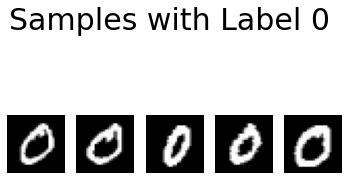

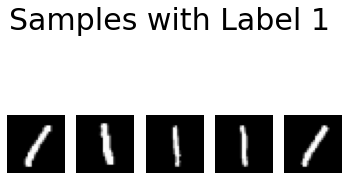

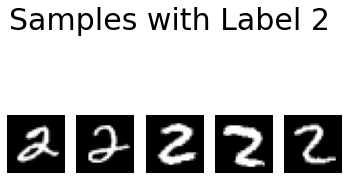

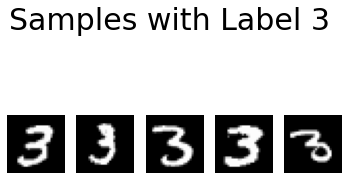

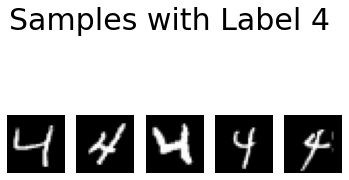

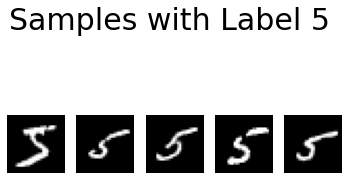

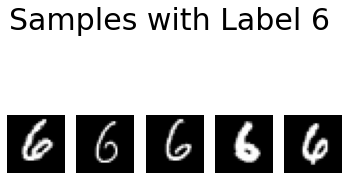

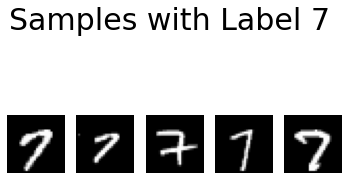

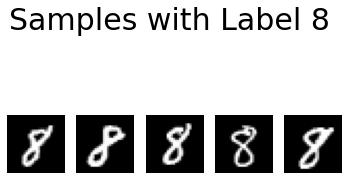

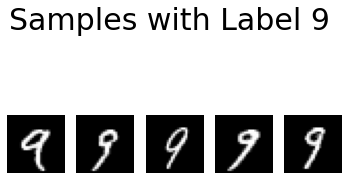

In [8]:
display_MNIST_samples(mnist_data)

### Generating the MNIST Extension
Here we define a function to easily extend the given MNIST dataset to a new dataset
- Using a given random generation seed, the generated dataset can be reproducible<br>(this was useful when testing and debugging the method, as it assured that for a given seed the same results will be produced each run)
- a None seed means entirely (pseudo)random gneration

In [9]:
def generate_extended_MNIST(
    mnist_data, samples_per_class: int = 5000, seed: int = None
) -> dict[str, np.ndarray]:
    mnist_images = mnist_data.data.numpy()
    mnist_lables = mnist_data.targets.numpy()
    indices = np.fromiter(range(len(mnist_images)), dtype=int)
    class_indices = {
        i: indices[mnist_lables == i] for i in range(len(mnist_data.classes))
    }

    class_count = 101
    dataset_size = class_count * samples_per_class
    height, width = mnist_images[0].shape
    extended_dataset = {
        "labels": np.repeat(
            np.fromiter(range(class_count), dtype=int), samples_per_class
        ),
        "images": np.empty((dataset_size, height, width * 3)),
    }

    rng = np.random.default_rng(seed)

    index = 0

    for i in range(class_count):
        label = f"{i:03d}"
        for _ in range(samples_per_class):
            first = rng.choice(class_indices[int(label[0])])
            second = rng.choice(class_indices[int(label[1])])
            third = rng.choice(class_indices[int(label[2])])
            new_image = np.concatenate(
                (mnist_images[first], mnist_images[second], mnist_images[third]),
                axis=1,
            )
            extended_dataset["images"][index] = new_image
            extended_dataset["labels"][index] = label

            index += 1

    return extended_dataset

In [10]:
extended_MNIST = generate_extended_MNIST(mnist_data, seed=1)
imgs = extended_MNIST["images"]
labels = extended_MNIST["labels"]

### Defining functions for random application of the transformations
as in the initial section of the work, the methods are categorized to geometric transformations, filters and numeric manipulations/noise: 

#### Applicable/Non-applicable transformations
in relation to the extended MNIST, the following restrictions are used for each augmentation:

- Flip: no restriction, although some flips will result with images seemingly from "different" classes<br>
this happens mostly on symmetric numbers (e.g. 800->008, 901->601)
- Rotate: because the image is not square, rotating too close to ±90° (±$\frac{\pi}{2}$ radians) cause an out-of-bounds clipping of the outermost digits.<br>
the angles of rotation must be restricted closer to 0 or 180° (0 or $\pi$ radians, respectfully)
- Translate: moving the image too far to the left or to the right again causes an out-of-bounds clipping of the left and the right digits, respectfully.
- Zoom: zooming too far in again causes an out-of-bounds clipping of the left and the right digits.
- Shear: too steep of an angle will either distort the number beyond recognition (for us humans at least..) or, again, causes an out-of-bounds clipping of digits.
- Sharpen: as far as we can tell, no restriction is neccessary (or can even be made)
- Mean/Median/Mode filters: because the image is quite small, a large enough kernel size will blurr out the image and destroy most of its features
- Gausssian blur: a large kernel size might blur the image too much, depending on the value of sigma (the s.d. of the gaussian distribution)
- Invert: simply inverts the image's colors.
- Cutout: too many holes/ too large holes will destroy an image's features
- Posterize: because the dataset is of white-on-black images, moderate posterization is fine
- Salt & pepper noise - the images are relatively small, so a small amount of noise can make a big difference and 'destroy' an image.<br>
When applying the noise, a very small percentage of the pixels are "selected" for the noise, exactly for that reason.
- Crop this augmentation is "special" as it is the only one changing the image dimensions - **It cannot be used for our purposes, as the dimensions are a prior knowledge**
    * sidenote - crop <u>can</u> be used if and only if resize is used immediately afterwards, to adjust the image dimensions

In [11]:
def apply_random_geometric_transformations(
    img: np.ndarray, n_transforms: int = 1, seed: int = None
) -> Tuple[str, np.ndarray]:
    rng = np.random.default_rng(seed)

    height, width = img.shape[:2]
    n_transforms = max(1, min(n_transforms, 5))
    selected_transforms = rng.choice(5, size=n_transforms, replace=False)
    augmented = img.copy()
    description = "GEOM:"
    for selection in selected_transforms:

        # flip
        if selection == 0:
            s = generate_seed(rng, 1000)
            augmented = flip(augmented, seed=s)
            description += f"F({s=})--"

        # rotate
        elif selection == 1:
            degrees = rng.integers(-20, 20) + 180 * rng.integers(2)
            theta = np.radians(degrees)
            augmented = rotate(augmented, theta)
            description += fr"R($\theta={degrees}\degree$)--"

        # translate
        elif selection == 2:
            tx = rng.integers(-width / 4, width / 4)
            ty = rng.integers(-height / 4, height / 4)
            augmented = translate(augmented, tx, ty)
            description += f"T({tx=},{ty=})--"

        # zoom
        elif selection == 3:
            ratio = 0.4 * rng.random() + 0.8
            augmented = zoom(augmented, ratio)
            description += f"Z(r={ratio:.2f})--"

        # shear
        else:
            horizontal = rng.random() > 0.5
            slope = 1 * rng.random() - 0.5
            augmented = shear(augmented, horizontal, slope)
            desc = "hor" if horizontal else "ver"
            description += f"S({desc},m={slope:.2f})--"

    description = description[:-2]

    return description, augmented


def apply_random_filter(
    img: np.ndarray, n_filters: int = 1, seed: int = None
) -> Tuple[str, np.ndarray]:
    rng = np.random.default_rng(seed)

    n_filters = max(1, min(n_filters, 5))
    selected_filters = rng.choice(5, size=n_filters, replace=False)
    augmented = img.copy()

    description = "FILT:"

    for selection in selected_filters:

        # sharpen
        if selection == 0:
            augmented = sharpen(img)
            description += "SH--"

        # mean filter
        elif selection == 1:
            augmented = mean_filter(img)
            description += "MEAN--"

        # median
        elif selection == 2:
            augmented = median_filter(img)
            description += "MED--"

        # mode
        elif selection == 3:
            augmented = mode_filter(img)
            description += "MODE--"

        # gaussian
        else:
            sigma = (0.5 - 0.1) * rng.random() + 0.1
            augmented = gaussian_blurr(img, 3, sigma)
            description += fr"GAUS($\sigma={sigma:.2f}$)--"

    description = description[:-2]

    return description, augmented


def apply_random_numeric_manipulation(
    img: np.ndarray, n_numeric: int = 1, seed: int = None
) -> Tuple[str, np.ndarray]:
    rng = np.random.default_rng(seed)

    n_numeric = max(1, min(n_numeric, 4))
    selected_numeric = rng.choice(4, size=n_numeric, replace=False)

    augmented = img.copy()

    augmented = cv.normalize(augmented, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)

    description = "NUM:"

    for selection in selected_numeric:

        # invert
        if selection == 0:
            augmented = invert(img)
            description += f"INV--"

        # cutout
        elif selection == 1:
            n = rng.integers(1, 5)
            w = rng.integers(2, 5)
            h = rng.integers(2, 5)
            f = rng.integers(256)
            s = generate_seed(rng, 1000)

            augmented = cutout(img, n, w, h, f, s)
            description += f"C({n},{w},{h},{f},{s=})--"

        # posterize
        elif selection == 2:
            n = rng.integers(2, 6)
            augmented = posterize(img, n)
            description += f"POST({n=})--"

        # salt & pepper noise
        else:
            size = img.shape[0] * img.shape[1]
            n = rng.integers(size * 0.004, size * 0.02)
            s = generate_seed(rng, 1000)
            augmented = salt_pepper_noise(img, n, s)
            description += f"SP({n=},{s=})--"

    description = description[:-2]

    return description, augmented

    # CROP CANNOT BE USED FOR OUR PURPOSES

### Augmentation Capability Display
Here we display 3 randomly selected images from the extended MNIST dataset we created, alongside 4 variations of each, with:
- 3 randomly selected geometric augmentation
- 1 filter
- and 1 numeric manipulation

As before, for the purpose of writing this work the seeds were predefined, but for display purposes all seeds were set to None

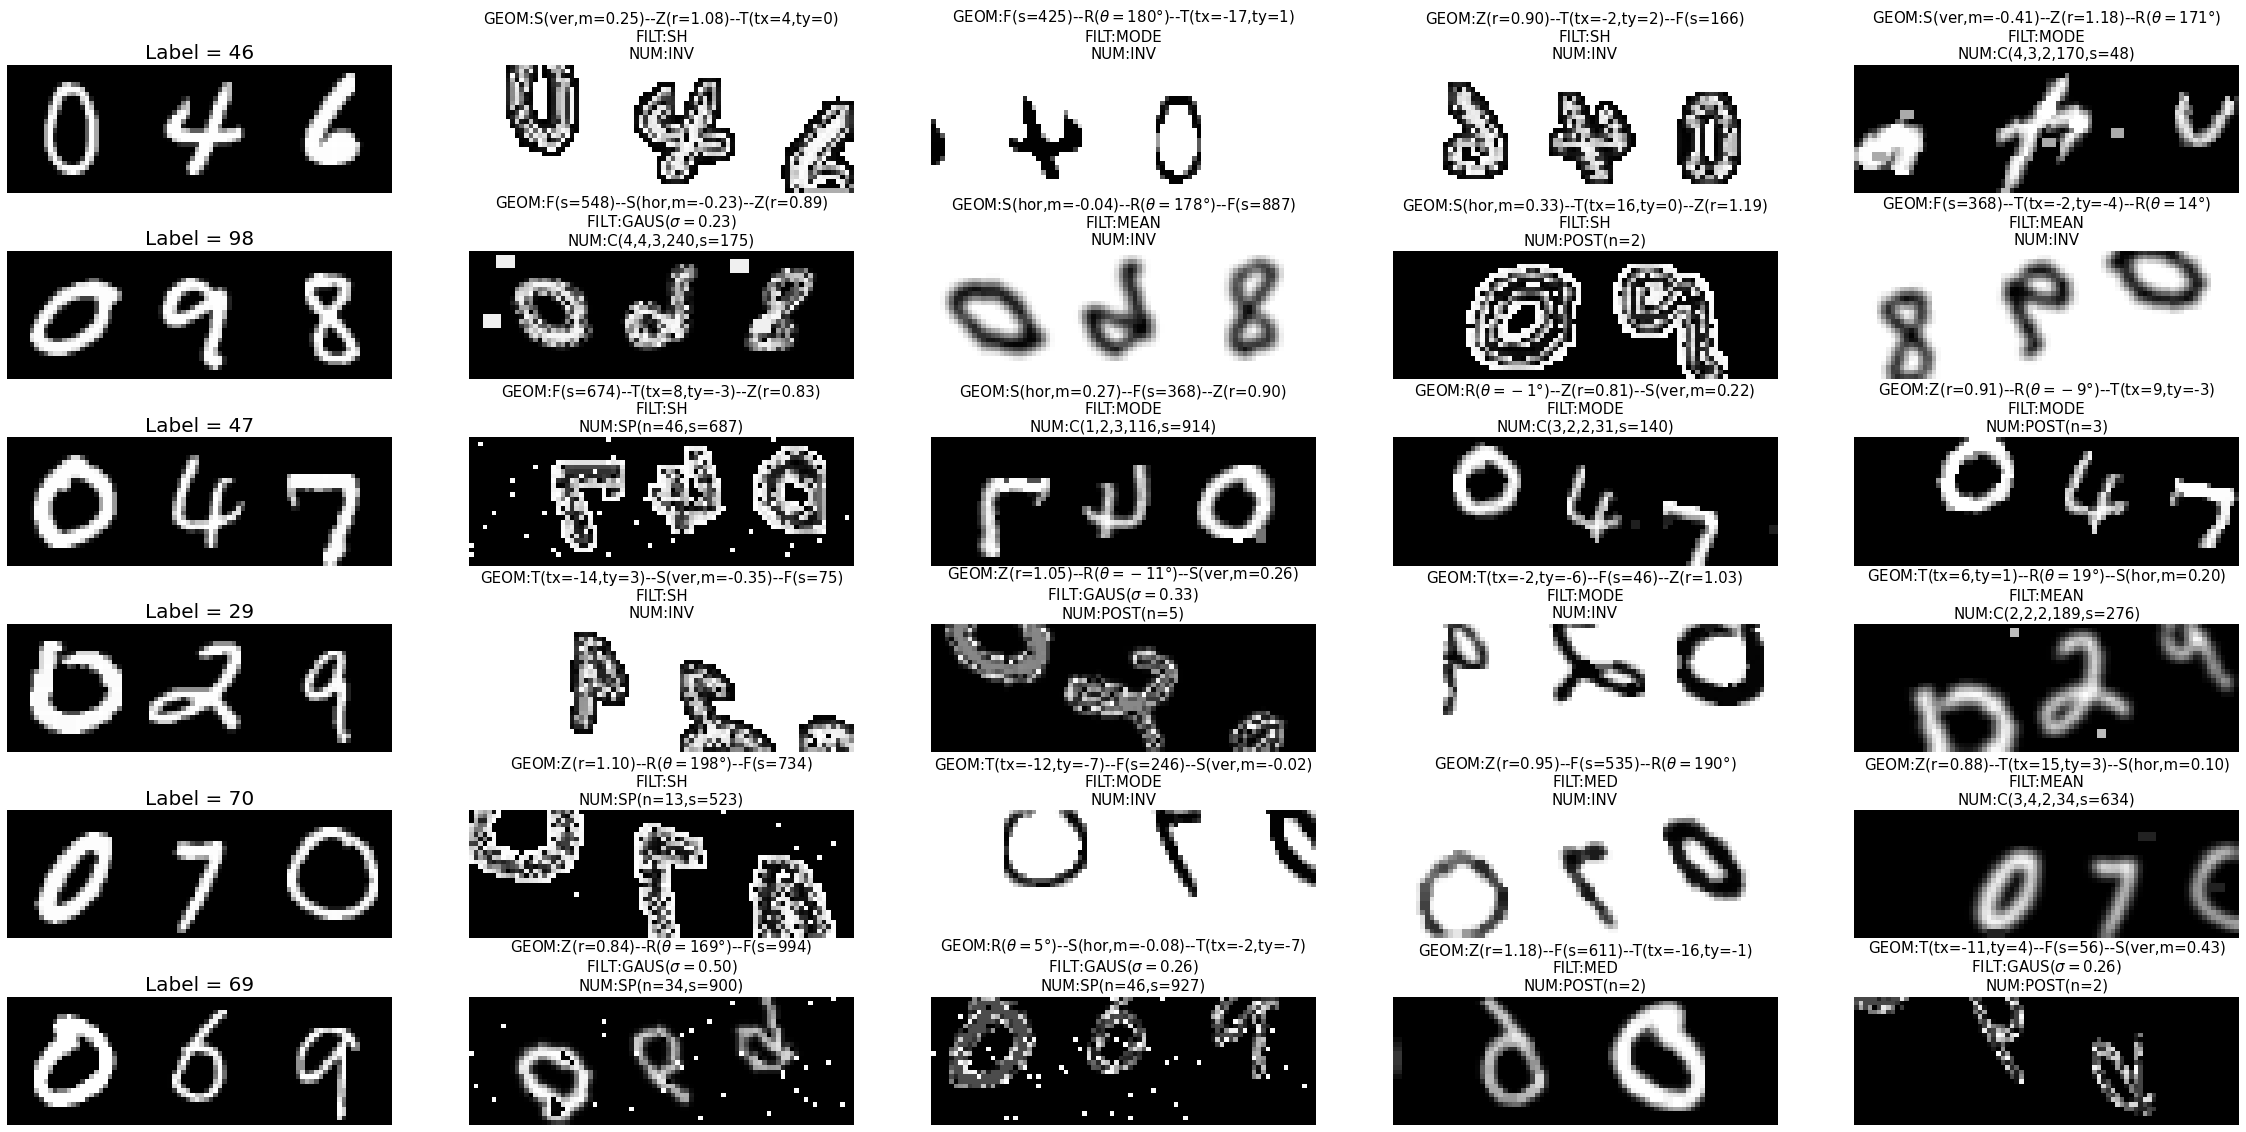

In [12]:
num_samples = 6

fig, axs = plt.subplots(nrows=num_samples, ncols=5, figsize=(40, 20))

rng = np.random.default_rng(None)

selected_indices = rng.integers(0, len(labels), num_samples)


for i, index in enumerate(selected_indices):

    axs[i, 0].imshow(imgs[index], **grayscale_options)
    axs[i, 0].set_title(f"Label = {labels[index]}", fontsize=20)
    axs[i, 0].set_axis_off()
    for j in range(1, 5):
        augmented = imgs[index]
        desc1, augmented = apply_random_geometric_transformations(
            augmented, 3, generate_seed(rng, None)
        )
        desc2, augmented = apply_random_filter(augmented, 1, generate_seed(rng, None))
        desc3, augmented = apply_random_numeric_manipulation(
            augmented, 1, generate_seed(rng, None)
        )

        axs[i, j].imshow(augmented, **grayscale_options)
        axs[i, j].set_title(f"{desc1}\n{desc2}\n{desc3}", fontsize=15)
        axs[i, j].set_axis_off()


plt.show()

## Task 2 - Generating a Shapes Dataset
As mentioned at the beginning, we have defined here 3 constants as per the requirements
Below the constants are the parameter-generating methods.
The parameters generated will be used by OpenCV's (cv) methods to draw the shapes in the empty dataset

In [13]:
IMG_SIZE = 50
MIN_AREA = 100
MAX_AREA = 600

Pixel = Tuple[int, int]


def generate_triangle_params(seed: int = None) -> Tuple[Pixel, Pixel, Pixel]:
    rng = np.random.default_rng(seed)

    y12 = rng.integers(IMG_SIZE)

    x1 = rng.choice(IMG_SIZE)

    x2_range = np.fromiter(range(IMG_SIZE), dtype=int)

    possible_base_len = abs(x1 - x2_range) + 1

    x2_range = x2_range[possible_base_len >= 4 * MIN_AREA / IMG_SIZE]

    x2 = rng.choice(x2_range)

    base_len = abs(x1 - x2) + 1

    y_range = np.fromiter(range(IMG_SIZE), dtype=int)

    possible_areas = base_len * (np.abs(y_range - y12) + 1) / 2

    y_range = y_range[(MIN_AREA <= possible_areas) & (possible_areas <= MAX_AREA)]

    y3 = rng.choice(y_range)

    x3 = rng.integers(IMG_SIZE)

    return ((x1, y12), (x2, y12), (x3, y3))


def generate_rectangle_params(seed: int = None,) -> Tuple[Pixel, Pixel]:
    rng = np.random.default_rng(seed)

    a = rng.integers(3, IMG_SIZE)

    b_range = np.fromiter(range(3, IMG_SIZE), dtype=int)

    possible_areas = a * b_range

    b_range = b_range[(MIN_AREA <= possible_areas) & (possible_areas <= MAX_AREA)]

    b = rng.choice(b_range)
    x1 = rng.integers(0, IMG_SIZE - a)
    y1 = rng.integers(0, IMG_SIZE - b)
    return ((x1, y1), (x1 + a - 1, y1 + b - 1))


def generate_ellipse_params(seed: int = None,) -> Tuple[Pixel, Pixel]:
    rng = np.random.default_rng(seed)

    a = rng.integers(3, IMG_SIZE / 2 - 1)

    b_range = np.fromiter(range(3, IMG_SIZE // 2 - 1), dtype=int)

    possible_areas = np.pi * a * b_range

    b_range = b_range[(MIN_AREA <= possible_areas) & (possible_areas <= MAX_AREA)]

    b = rng.choice(b_range)

    centerx = rng.integers(a + 1, IMG_SIZE - (a + 1))
    centery = rng.integers(b + 1, IMG_SIZE - (b + 1))

    return ((centerx, centery), (a, b))

### generating the Dataset
The dataset is generated in a similar fashion to the extended MNIST dataset above, and as per request the labels are 0 for triangles, 1 for rectangles, and 2 for ellipses.

In [14]:
def generate_shapes_dataset(
    samples_per_class: int = 500, seed: int = None
) -> dict[str, np.ndarray]:

    shapes_dataset = {
        "labels": np.repeat([0, 1, 2], samples_per_class),
        "images": np.zeros((3 * samples_per_class, IMG_SIZE, IMG_SIZE, 3)),
    }

    rng = np.random.default_rng(seed)

    colors = mcolors.CSS4_COLORS
    by_hsv = sorted(
        (tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))), name)
        for name, color in colors.items()
    )
    names = [name for hsv, name in by_hsv]

    colors = [ImageColor.getrgb(colors[name]) for name in names]

    chosen_colors = rng.choice(colors[12:], size=1500).tolist()
    for i in range(samples_per_class):
        tri_ind = i
        rect_ind = samples_per_class + i
        ell_ind = 2 * samples_per_class + i

        triangle_image = shapes_dataset["images"][tri_ind]
        rectangle_image = shapes_dataset["images"][rect_ind]
        ellipse_image = shapes_dataset["images"][ell_ind]

        points = np.array([[*generate_triangle_params(generate_seed(rng, tri_ind))]])
        cv.fillPoly(triangle_image, points, chosen_colors[tri_ind])

        points = generate_rectangle_params(generate_seed(rng, rect_ind))
        cv.rectangle(rectangle_image, *points, chosen_colors[rect_ind], cv.FILLED)

        points = generate_ellipse_params(generate_seed(rng, ell_ind))
        cv.ellipse(ellipse_image, *points, 0, 0, 360, chosen_colors[ell_ind], cv.FILLED)

    shapes_dataset["images"] = shapes_dataset["images"].astype(int)

    return shapes_dataset

In [15]:
shapes_dataset = generate_shapes_dataset(seed=1)

### Generating randomly augmented images
(as taken from lab 3 with slight modification)
Starting with the 'original' house image, for each image, each augmentation is either applied or not (probability 0.5), in the following order:
1. (F)lip
1. (R)otate (with randomized `theta` between 0 and $2\pi$)
1. (G)aussian Blur (with `kernel_size`=21 and `sigma` randomized between 0.1 and 1)
1. (C)rop (around the center, with randomized ratio between 0.3 and 1) # **should not be used for training as it changes the image's dimensions**
1. (S)harpen

Each image will have the applied transformation's initial as part of the title, alongside the parameters given to the transformation

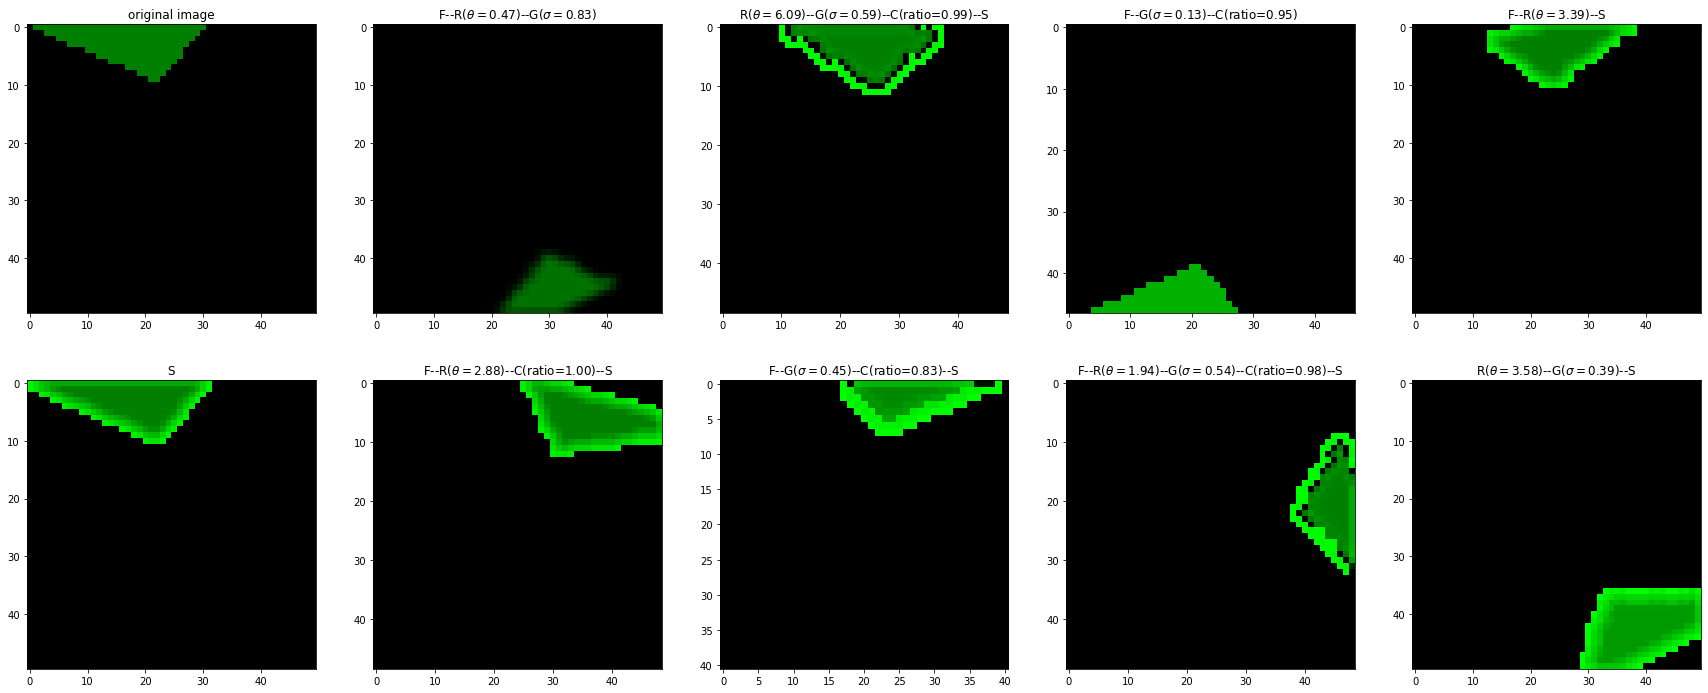

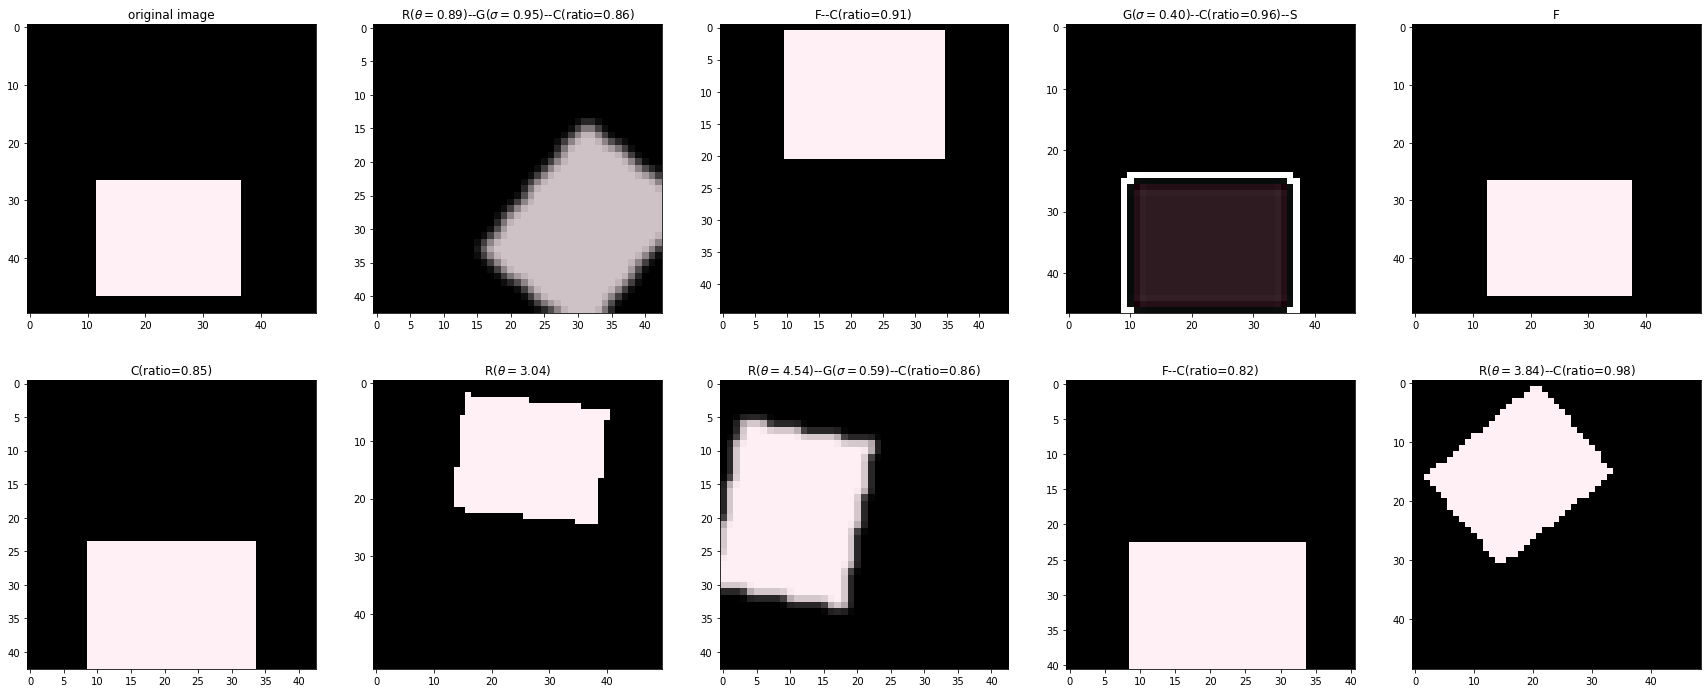

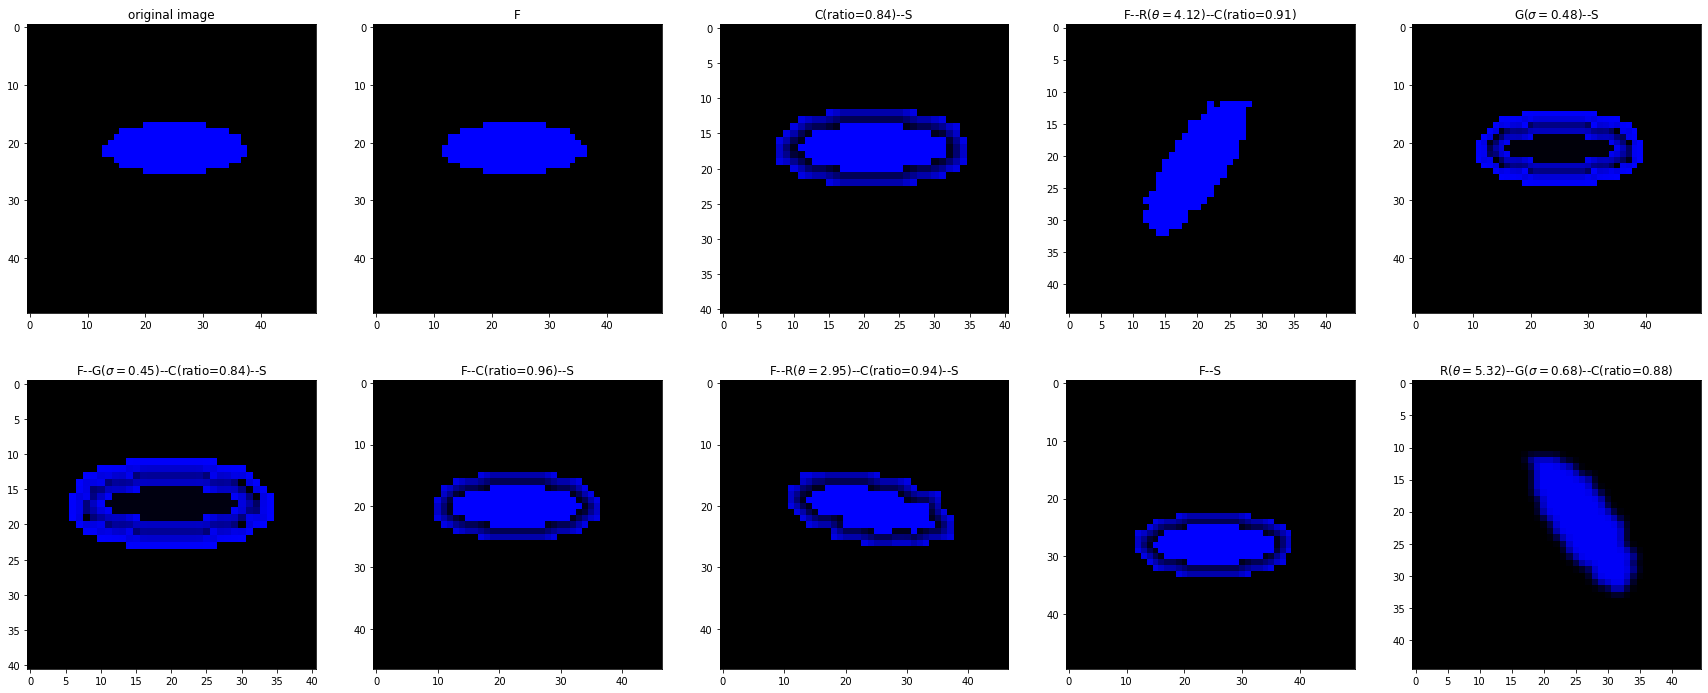

In [16]:
def display_image_augmentations(img: np.ndarray, seed: int = None) -> None:
    fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(30, 12))
    rng = np.random.default_rng(seed)
    axs[0, 0].imshow(img)
    axs[0, 0].set_title("original image")

    for ax in np.reshape(axs, 10)[1:]:
        augmented = img.copy()
        title = ""
        options = rng.integers(2, size=5)
        while not any(options):
            options = rng.integers(2, size=5)

        # flip
        if options[0]:
            augmented = flip(augmented, rng)
            title += "F--"

        # rotate
        if options[1]:
            theta = np.radians(rng.integers(360))
            augmented = rotate(augmented, theta)
            title += fr"R($\theta={theta:.2f}$)--"

        # gaussian
        if options[2]:
            sigma = (1 - 0.1) * rng.random() + 0.1
            augmented = gaussian_blurr(augmented, 3, sigma)
            title += fr"G($\sigma={sigma:.2f}$)--"

        # crop
        if options[3]:
            ratio = (1 - 0.8) * rng.random() + 0.8
            shape = np.array(augmented.shape)
            top_left = ((1 - ratio) * shape / 2).astype(int)
            bottom_right = ((1 + ratio) * shape / 2).astype(int)
            augmented = crop(
                augmented, top_left[0], top_left[1], bottom_right[0], bottom_right[1]
            )
            title += f"C(ratio={ratio:.2f})--"

        # sharpen
        if options[4]:
            augmented = sharpen(augmented)
            title += "S--"

        title = title[:-2]
        ax.imshow(to_uint8(augmented))
        ax.set_title(title)

    plt.show()


rng = np.random.default_rng(1)


for i in range(3):
    image = shapes_dataset["images"][i * 500 + rng.integers(500)]
    display_image_augmentations(image, i)

In [17]:
def split_train_test(
    dataset: Dict[str, np.ndarray], seed: int = None
) -> Tuple[Dict[str, np.ndarray], Dict[str, np.ndarray]]:
    rng = np.random.default_rng(seed)
    dataset_size = len(dataset["labels"])
    indices = list(range(dataset_size))

    train_indices = rng.choice(
        indices, int(dataset_size * 0.9), replace=False, shuffle=False
    )

    test_indices = np.setdiff1d(indices, train_indices)

    imgs = dataset["images"]
    lbls = dataset["labels"]

    train_imgs = imgs[train_indices]
    train_lbls = lbls[train_indices]

    test_imgs = imgs[test_indices]
    test_lbls = lbls[test_indices]

    train_data = {"images": train_imgs, "labels": train_lbls}
    test_data = {"images": test_imgs, "labels": test_lbls}

    return train_data, test_data

In [18]:
train, test = split_train_test(shapes_dataset, seed=1)

print(
    train["images"].shape,
    train["labels"].shape,
    test["images"].shape,
    test["labels"].shape,
)

(1350, 50, 50, 3) (1350,) (150, 50, 50, 3) (150,)
